# GAN

9.2.1 학습 준비

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 학습에 필요한 하이퍼파라미터 설정
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 장치를 사용합니다: ", DEVICE)

다음 장치를 사용합니다:  cpu


In [3]:
# 학습에 필요한 데이터셋 읽기
trainset = datasets.FashionMNIST('./data', train = True, download = True, transform = transforms.Compose([
    transforms.ToTensor(), transforms. Normalize((0.5,),(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True)

9.2.2 생성자와 판별자 구현

In [4]:
# 생성자(실제 데이터와 비슷한 가짜 데이터를 만들어 내는 신경망, Generator)
# 생성자는 정규분포로부터 뽑은 64차원의 무작위 텐서를 입력받음

G = nn.Sequential( nn.Linear(64,256), nn.ReLU(),nn.Linear(256,256), nn.ReLU(), nn.Linear(256,784), nn.Tanh())

In [5]:
# 판별자(생성자가 만든 이미지가 가짜 이미지인지, 실제 Fashion MNIST의 이미지인지 구분하는 분류 모델, Discriminator)

D = nn.Sequential( nn.Linear(784,256), nn.LeakyReLU(0.2),nn.Linear(256,256), nn.LeakyReLU(0.2), nn.Linear(256,1), nn.Sigmoid())

9.2.3 GAN 학습 구현

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

criterion = nn.BCELoss()  # 이진 교차 엔트로피 오차 함수(레이블이 가짜,진짜 2가지 뿐이므로 BCE 사용)
d_optimizer = optim.Adam(D.parameters(),lr = 0.0002)  # Adam 모듈로 최적화
g_optimizer = optim.Adam(G.parameters(),lr = 0.0002)
total_step = len(train_loader)

In [7]:
# GAN을 학습시키는 반복문

for epoch in range(EPOCHS):
    for i,(images,_) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE,-1).to(DEVICE) # 왜 하는지 질문  
        
        # 진짜와 가짜(생성자가 만든 이미지) 이미지에 레이블 달기 위해 두 레이블 텐서 정의 (진짜와 가짜 레이블 생성)
        real_labels=torch.ones(BATCH_SIZE, 1).to(DEVICE)  # batch_size는 행
        fake_labels=torch.zeros(BATCH_SIZE, 1).to(DEVICE)
    
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
        outputs = D(images)
        d_loss_real = criterion(outputs,real_labels)  # real_labels는 1이니까 결국 output하고 1하고 비교하는건가?
        real_score = outputs    

        # 무작위 텐서로 가짜 이미지 생성
        z=torch.randn(BATCH_SIZE, 64).to(DEVICE)  # 난수값으로 구성된 '배치 사이즈 * 64 텐서' 생성
        fake_images = G(z)

        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs,fake_labels)
        fake_score = outputs

        # 진짜와 가짜 이미지를 가지고 낸 오차를 더해서 판별자 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        d_loss.backward()
        d_optimizer.step()

        # 생성자 학습(생성자 결과물과 real_labels사이의 오차를 최소화하는 식으로 학습 진행해야함)
        # 생성자가 판별자를 속였는지에 대한 오차 계산

        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs,real_labels)  # 생성자 오차

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'.format(epoch,EPOCHS,d_loss.item(),g_loss.item(),
                                                                                 real_score.mean().item(), fake_score.mean().item()))

이폭 [0/500] d_loss:0.0288 g_loss:5.1510 D(x):0.99 D(G(z)):0.01
이폭 [1/500] d_loss:0.0362 g_loss:5.4823 D(x):1.00 D(G(z)):0.03
이폭 [2/500] d_loss:0.0484 g_loss:7.1102 D(x):0.98 D(G(z)):0.01
이폭 [3/500] d_loss:0.0297 g_loss:6.9068 D(x):0.98 D(G(z)):0.01
이폭 [4/500] d_loss:0.0653 g_loss:4.4412 D(x):0.97 D(G(z)):0.02
이폭 [5/500] d_loss:0.1550 g_loss:6.4459 D(x):0.95 D(G(z)):0.01
이폭 [6/500] d_loss:0.2146 g_loss:4.4516 D(x):0.96 D(G(z)):0.08
이폭 [7/500] d_loss:0.0973 g_loss:4.9790 D(x):0.97 D(G(z)):0.03
이폭 [8/500] d_loss:0.1068 g_loss:7.1968 D(x):0.97 D(G(z)):0.04
이폭 [9/500] d_loss:0.1462 g_loss:4.2776 D(x):0.96 D(G(z)):0.05
이폭 [10/500] d_loss:0.3175 g_loss:3.4291 D(x):0.93 D(G(z)):0.16
이폭 [11/500] d_loss:0.2256 g_loss:4.3459 D(x):0.94 D(G(z)):0.06
이폭 [12/500] d_loss:0.3180 g_loss:4.9590 D(x):0.91 D(G(z)):0.04
이폭 [13/500] d_loss:0.3514 g_loss:3.8039 D(x):0.93 D(G(z)):0.14
이폭 [14/500] d_loss:0.6398 g_loss:4.0610 D(x):0.84 D(G(z)):0.14
이폭 [15/500] d_loss:0.2512 g_loss:4.4481 D(x):0.94 D(G(z)):0.08
이폭

이폭 [130/500] d_loss:0.7681 g_loss:1.4892 D(x):0.76 D(G(z)):0.31
이폭 [131/500] d_loss:1.1957 g_loss:1.3750 D(x):0.69 D(G(z)):0.40
이폭 [132/500] d_loss:1.1800 g_loss:1.8911 D(x):0.54 D(G(z)):0.24
이폭 [133/500] d_loss:1.1491 g_loss:1.3119 D(x):0.73 D(G(z)):0.41
이폭 [134/500] d_loss:1.2526 g_loss:1.1997 D(x):0.66 D(G(z)):0.42
이폭 [135/500] d_loss:0.8818 g_loss:1.2418 D(x):0.73 D(G(z)):0.34
이폭 [136/500] d_loss:0.7071 g_loss:1.6915 D(x):0.75 D(G(z)):0.25
이폭 [137/500] d_loss:0.7727 g_loss:1.8516 D(x):0.74 D(G(z)):0.28
이폭 [138/500] d_loss:0.9376 g_loss:1.8143 D(x):0.65 D(G(z)):0.26
이폭 [139/500] d_loss:0.9588 g_loss:1.7441 D(x):0.69 D(G(z)):0.27
이폭 [140/500] d_loss:0.9273 g_loss:1.5258 D(x):0.68 D(G(z)):0.29
이폭 [141/500] d_loss:0.9940 g_loss:1.6352 D(x):0.64 D(G(z)):0.29
이폭 [142/500] d_loss:0.9574 g_loss:1.3776 D(x):0.71 D(G(z)):0.36
이폭 [143/500] d_loss:0.6363 g_loss:2.3921 D(x):0.72 D(G(z)):0.17
이폭 [144/500] d_loss:1.0224 g_loss:1.4189 D(x):0.68 D(G(z)):0.34
이폭 [145/500] d_loss:0.9169 g_loss:1.4093

이폭 [259/500] d_loss:1.0411 g_loss:1.1538 D(x):0.66 D(G(z)):0.38
이폭 [260/500] d_loss:1.0173 g_loss:1.5523 D(x):0.63 D(G(z)):0.29
이폭 [261/500] d_loss:0.8994 g_loss:1.4834 D(x):0.71 D(G(z)):0.34
이폭 [262/500] d_loss:0.9519 g_loss:1.1758 D(x):0.71 D(G(z)):0.39
이폭 [263/500] d_loss:0.8874 g_loss:1.5253 D(x):0.65 D(G(z)):0.29
이폭 [264/500] d_loss:1.3571 g_loss:1.0218 D(x):0.59 D(G(z)):0.44
이폭 [265/500] d_loss:1.2260 g_loss:1.4421 D(x):0.59 D(G(z)):0.35
이폭 [266/500] d_loss:1.1683 g_loss:1.2065 D(x):0.61 D(G(z)):0.38
이폭 [267/500] d_loss:1.0086 g_loss:1.3101 D(x):0.61 D(G(z)):0.32
이폭 [268/500] d_loss:0.9200 g_loss:1.2338 D(x):0.71 D(G(z)):0.37
이폭 [269/500] d_loss:0.9516 g_loss:1.5503 D(x):0.64 D(G(z)):0.29
이폭 [270/500] d_loss:1.1998 g_loss:1.1913 D(x):0.64 D(G(z)):0.42
이폭 [271/500] d_loss:0.9883 g_loss:1.5958 D(x):0.62 D(G(z)):0.30
이폭 [272/500] d_loss:1.3222 g_loss:1.0738 D(x):0.57 D(G(z)):0.40
이폭 [273/500] d_loss:0.9813 g_loss:1.3339 D(x):0.66 D(G(z)):0.34
이폭 [274/500] d_loss:0.6562 g_loss:1.7713

이폭 [388/500] d_loss:0.9070 g_loss:1.7111 D(x):0.71 D(G(z)):0.30
이폭 [389/500] d_loss:1.0372 g_loss:1.3935 D(x):0.64 D(G(z)):0.31
이폭 [390/500] d_loss:0.9605 g_loss:1.3299 D(x):0.67 D(G(z)):0.32
이폭 [391/500] d_loss:1.1376 g_loss:1.3377 D(x):0.63 D(G(z)):0.37
이폭 [392/500] d_loss:0.8060 g_loss:1.3476 D(x):0.77 D(G(z)):0.34
이폭 [393/500] d_loss:0.8544 g_loss:1.6273 D(x):0.68 D(G(z)):0.27
이폭 [394/500] d_loss:0.9436 g_loss:1.2599 D(x):0.70 D(G(z)):0.35
이폭 [395/500] d_loss:1.0771 g_loss:1.2853 D(x):0.70 D(G(z)):0.39
이폭 [396/500] d_loss:0.9405 g_loss:1.3613 D(x):0.69 D(G(z)):0.32
이폭 [397/500] d_loss:1.3280 g_loss:1.0882 D(x):0.60 D(G(z)):0.43
이폭 [398/500] d_loss:1.2944 g_loss:1.1695 D(x):0.60 D(G(z)):0.40
이폭 [399/500] d_loss:0.9490 g_loss:1.4193 D(x):0.67 D(G(z)):0.33
이폭 [400/500] d_loss:1.2202 g_loss:1.2619 D(x):0.57 D(G(z)):0.35
이폭 [401/500] d_loss:0.8220 g_loss:1.5355 D(x):0.73 D(G(z)):0.30
이폭 [402/500] d_loss:0.8449 g_loss:1.5027 D(x):0.75 D(G(z)):0.34
이폭 [403/500] d_loss:0.8626 g_loss:1.4591

9.2.4 결과를 시각화

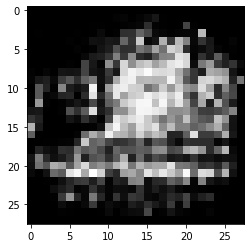

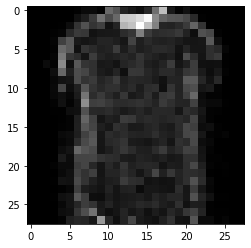

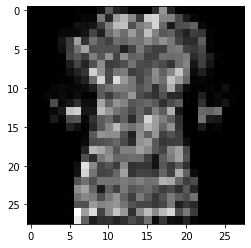

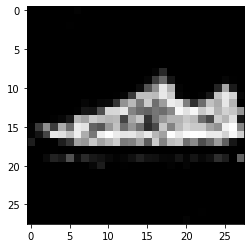

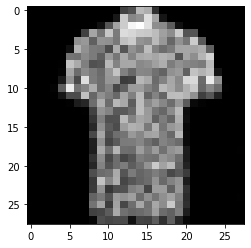

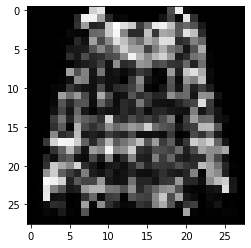

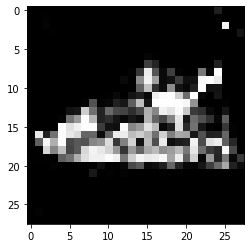

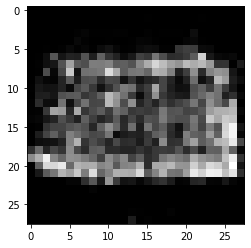

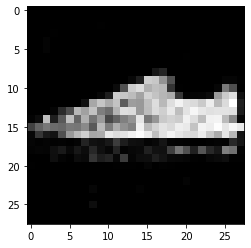

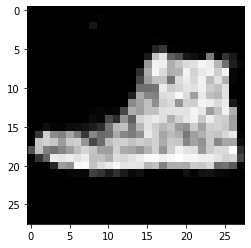

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28,28))
    plt.imshow(fake_images_img,cmap='gray')
    plt.show()

# 9.3 cGAN으로 생성 제어하기

9.3.2 조건부 생성자와 판별자

In [9]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [11]:
# 학습에 필요한 데이터셋 읽기
trainset = datasets.FashionMNIST('./data', train = True, download = True, transform = transforms.Compose([
    transforms.ToTensor(), transforms. Normalize((0.5,),(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True)

In [12]:
# 생성자

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.embed = nn.Embedding(10,10)  # 연속적인 텐서를 레이블값에 단순 대입(매핑)한다고 보면됨 -> 무작위 텐서 100개를 10개의 레이블로 매핑?
    
        # 이번 예제에서는 무작위 텐서(z)의 크기를 100으로 함. 그런데 생성자 첫 계층이 110개의 값을 받는 이유는 나머지 10은 레이블에 관한 정보여서
        # cGAN의 생성자는 무작위로 생성한 레이블 정보를 받아 해당 레이블에 대한 이미지를 생성하도록 학습됨
        # inplace = True설정은 입력을 복사하지 않고 바로 조작한다는 뜻 -> 무슨 뜻?
        self.model = nn.Sequential(nn.Linear(110,256), nn.LeakyReLU(0.2,inplace = True),nn.Linear(256,512), nn.LeakyReLU(0.2,inplace = True),
                               nn.Linear(512,1024), nn.LeakyReLU(0.2,inplace = True),nn.Linear(1024,784), nn.Tanh())
        
    def forward(self,z,labels):
        c = self.embed(labels)
        x = torch.cat([z,c],1)  # 무작위 벡터와 클래스 레이블을 이어 붙임
        return self.model(x)

In [13]:
# 판별자(판별자도 레이블 정보를 받음)
# 레이블이 주어졌을 때 가짜인 확률과 진짜인 확률을 추정

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10,10)
        
        # 판별자에게도 레이블 정보를 전달하기 위해 이미지크기 784에 10을 더해 794를 전달
        # 성능을 늘리기 위해 드롭아웃 계층을 추가
        self.model = nn.Sequential(nn.Linear(794,1024), nn.LeakyReLU(0.2,inplace = True),nn.Dropout(0.3),
                                   nn.Linear(1024,512), nn.LeakyReLU(0.2,inplace = True),nn.Dropout(0.3),
                                   nn.Linear(512,256), nn.LeakyReLU(0.2,inplace = True),nn.Dropout(0.3),nn.Linear(256,1), nn.Sigmoid())
    
    def forward(self,x,labels):
        c = self.embed(labels)
        x = torch.cat([x,c],1)
        return self.model(x)

In [14]:
# 모델의 인스턴스 만들고 모델의 가중치를 지정한 장치로 보낸다

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [15]:
criterion = nn.BCELoss()  # 오차함수(이진 교차 엔트로피 함수)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)  # 최적화 함수
g_optimizer = optim.Adam(D.parameters(), lr=0.0002)

In [16]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images,labels) in enumerate(train_loader):   # 이번에는 데이터로더의 두 번째 반환값도 사용할 것이므로 labels 표기해줌
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # 진짜와 가짜 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산(데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성하기
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake  # 진짜 이미지 + 가짜 이미지  = 판별자 오차 

        # 판별자 모델의 학습 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차
        fake_images = G(z,g_label)   # 생성자 
        outputs = D(fake_images, g_label)  # 판별자  
        g_loss = criterion(outputs,real_labels)
        
        # 생성자 모델 학습 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'.format(epoch,EPOCHS,d_loss.item(),g_loss.item(),
                                                                                 real_score.mean().item(), fake_score.mean().item()))

이폭 [0/300] d_loss:1.3877 g_loss:0.3341 D(x):1.00 D(G(z)):0.75
이폭 [1/300] d_loss:1.3748 g_loss:0.3341 D(x):1.00 D(G(z)):0.75
이폭 [2/300] d_loss:1.3703 g_loss:0.3260 D(x):1.00 D(G(z)):0.74
이폭 [3/300] d_loss:1.3712 g_loss:0.3247 D(x):1.00 D(G(z)):0.74
이폭 [4/300] d_loss:1.3768 g_loss:0.3191 D(x):1.00 D(G(z)):0.75
이폭 [5/300] d_loss:1.3797 g_loss:0.3154 D(x):1.00 D(G(z)):0.75
이폭 [6/300] d_loss:1.3673 g_loss:0.3194 D(x):1.00 D(G(z)):0.74
이폭 [7/300] d_loss:1.3626 g_loss:0.3112 D(x):1.00 D(G(z)):0.74
이폭 [8/300] d_loss:1.3513 g_loss:0.3184 D(x):1.00 D(G(z)):0.74
이폭 [9/300] d_loss:1.3713 g_loss:0.3182 D(x):1.00 D(G(z)):0.74
이폭 [10/300] d_loss:1.3669 g_loss:0.3163 D(x):1.00 D(G(z)):0.74
이폭 [11/300] d_loss:1.3833 g_loss:0.3154 D(x):1.00 D(G(z)):0.75
이폭 [12/300] d_loss:1.3699 g_loss:0.3193 D(x):1.00 D(G(z)):0.74
이폭 [13/300] d_loss:1.3908 g_loss:0.3126 D(x):1.00 D(G(z)):0.75
이폭 [14/300] d_loss:1.3667 g_loss:0.3115 D(x):1.00 D(G(z)):0.74
이폭 [15/300] d_loss:1.3710 g_loss:0.3107 D(x):1.00 D(G(z)):0.74
이폭

이폭 [130/300] d_loss:1.4378 g_loss:0.2927 D(x):1.00 D(G(z)):0.76
이폭 [131/300] d_loss:1.4452 g_loss:0.2762 D(x):1.00 D(G(z)):0.76
이폭 [132/300] d_loss:1.4601 g_loss:0.2792 D(x):1.00 D(G(z)):0.77
이폭 [133/300] d_loss:1.4517 g_loss:0.2800 D(x):1.00 D(G(z)):0.76
이폭 [134/300] d_loss:1.4552 g_loss:0.2820 D(x):1.00 D(G(z)):0.76
이폭 [135/300] d_loss:1.4472 g_loss:0.2765 D(x):1.00 D(G(z)):0.76
이폭 [136/300] d_loss:1.4347 g_loss:0.2745 D(x):1.00 D(G(z)):0.76
이폭 [137/300] d_loss:1.4675 g_loss:0.2762 D(x):1.00 D(G(z)):0.77
이폭 [138/300] d_loss:1.4506 g_loss:0.2855 D(x):1.00 D(G(z)):0.76
이폭 [139/300] d_loss:1.4448 g_loss:0.2815 D(x):1.00 D(G(z)):0.76
이폭 [140/300] d_loss:1.4419 g_loss:0.2760 D(x):1.00 D(G(z)):0.76
이폭 [141/300] d_loss:1.4677 g_loss:0.2803 D(x):1.00 D(G(z)):0.77
이폭 [142/300] d_loss:1.4476 g_loss:0.2814 D(x):1.00 D(G(z)):0.76
이폭 [143/300] d_loss:1.4526 g_loss:0.2814 D(x):1.00 D(G(z)):0.76
이폭 [144/300] d_loss:1.4443 g_loss:0.2779 D(x):1.00 D(G(z)):0.76
이폭 [145/300] d_loss:1.4723 g_loss:0.2804

이폭 [259/300] d_loss:3.0899 g_loss:0.5358 D(x):1.00 D(G(z)):0.84
이폭 [260/300] d_loss:3.1179 g_loss:0.4690 D(x):1.00 D(G(z)):0.83
이폭 [261/300] d_loss:3.4379 g_loss:0.5994 D(x):1.00 D(G(z)):0.84
이폭 [262/300] d_loss:3.4320 g_loss:0.7484 D(x):1.00 D(G(z)):0.83
이폭 [263/300] d_loss:3.3660 g_loss:0.8695 D(x):1.00 D(G(z)):0.84
이폭 [264/300] d_loss:3.6474 g_loss:0.8487 D(x):0.99 D(G(z)):0.82
이폭 [265/300] d_loss:3.5161 g_loss:0.6461 D(x):1.00 D(G(z)):0.83
이폭 [266/300] d_loss:2.8882 g_loss:0.6967 D(x):1.00 D(G(z)):0.81
이폭 [267/300] d_loss:2.9612 g_loss:0.6553 D(x):0.99 D(G(z)):0.81
이폭 [268/300] d_loss:3.2094 g_loss:0.6001 D(x):1.00 D(G(z)):0.85
이폭 [269/300] d_loss:3.4223 g_loss:0.7275 D(x):1.00 D(G(z)):0.87
이폭 [270/300] d_loss:2.8322 g_loss:0.7492 D(x):1.00 D(G(z)):0.82
이폭 [271/300] d_loss:2.6727 g_loss:0.7554 D(x):1.00 D(G(z)):0.80
이폭 [272/300] d_loss:2.6089 g_loss:0.6334 D(x):1.00 D(G(z)):0.80
이폭 [273/300] d_loss:2.3009 g_loss:0.7086 D(x):1.00 D(G(z)):0.79
이폭 [274/300] d_loss:2.4739 g_loss:0.6313

9.3.4 결과물 시각화

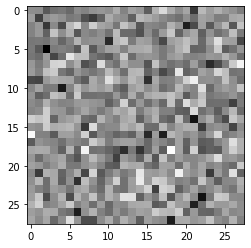

In [17]:
# 패션 아이템을 선택적으로 생성해 결과물을 시각화 하기

item_number = 9  # 아이템 번호
# 무작위 텐서 z와 레이블 정보 g_label은 하나의 이미지만 출력하기 위해 배치 크기를 1로 지정함
z = torch.randn(1,100).to(DEVICE)
g_label = torch.full((1,), item_number, dtype = torch.long).to(DEVICE)  # torch.full은 새로운 텐서를 만드는 함수
sample_images = G(z,g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28,28))

plt.imshow(sample_images_img, cmap='gray')
plt.show()